# Ball and Stick

*(Behrens et al. 2003)* proposed to represent the intra-axonal diffusion as a Stick - a cylinder with zero radius - and the extra-axonal diffusion as a Ball - an isotropic Gaussian compartment.

\begin{equation}
 E^{\textrm{Ball and}}_{\textrm{Sticks}}=\underbrace{f_h\overbrace{E_{iso}(\lambda_{\textrm{iso}})}^{\textrm{Ball}}}_{\textrm{Extra-Axonal}}+ \sum_{i=1}^{N}\underbrace{f_{i,r}\overbrace{E_r(\boldsymbol{\mu}_i|\lambda_\parallel)}^{\textrm{Stick}}}_{\textrm{Intra-Axonal}}
\end{equation}

For this first example, we will restrict ourselves to the case where $N$=2

# Human Connectome Project Example

In [1]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


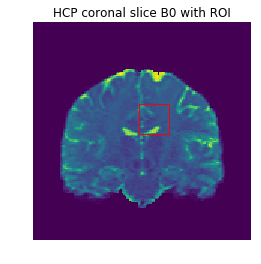

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(1)
ax.imshow(data_hcp[:, 0, :, 0].T, origin=True)
rect = patches.Rectangle((70,70),20,20,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('HCP coronal slice B0 with ROI');

In [3]:
data_hcp_small = data_hcp[70:90, :, 70:90]

## Generate Ball and Stick model

In [4]:
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel
ball = gaussian_models.G1Ball()
stick1 = cylinder_models.C1Stick()
stick2 = cylinder_models.C1Stick()
BAS_mod = MultiCompartmentModel(models=[ball, stick1, stick2])

In [5]:
BAS_mod.parameter_cardinality

OrderedDict([('C1Stick_2_mu', 2),
             ('G1Ball_1_lambda_iso', 1),
             ('C1Stick_1_mu', 2),
             ('C1Stick_1_lambda_par', 1),
             ('C1Stick_2_lambda_par', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1),
             ('partial_volume_2', 1)])

In [6]:
BAS_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 3e-9)

In [7]:
BAS_mod.parameter_cardinality

OrderedDict([('C1Stick_2_mu', 2),
             ('C1Stick_1_mu', 2),
             ('C1Stick_1_lambda_par', 1),
             ('C1Stick_2_lambda_par', 1),
             ('partial_volume_0', 1),
             ('partial_volume_1', 1),
             ('partial_volume_2', 1)])

## Fit Ball and Sticks model to HCP data

In [8]:
BAS_fit_hcp = BAS_mod.fit(scheme_hcp, data_hcp_small)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 80.1930429935 seconds
Fitting of 400 voxels complete in 80.4078359604 seconds.
Average of 0.201019589901 seconds per voxel.


In [9]:
from dipy.viz import fvtk
from dipy.viz.actor import slicer
import numpy as np
affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10

volume1 = BAS_fit_hcp.fitted_parameters['partial_volume_1']
volume2 = BAS_fit_hcp.fitted_parameters['partial_volume_2']
volume_im = slicer(1. - BAS_fit_hcp.fitted_parameters['partial_volume_0'][:, 0, :, None],
                   interpolation='nearest', affine=affine, opacity=0.7)

peak_intensities = np.concatenate([volume1[..., None], volume2[..., None]], axis=-1)

ren = fvtk.ren()
peaks = BAS_fit_hcp.peaks_cartesian()
peaks_fvtk = fvtk.peaks(peaks, peak_intensities, scale=1.)
peaks_fvtk.RotateX(90)
peaks_fvtk.RotateZ(180)
peaks_fvtk.RotateY(180)
fvtk.add(ren, peaks_fvtk)
fvtk.add(ren, volume_im)
fvtk.record(ren=ren, size=[700, 700], out_path='dipy.png')

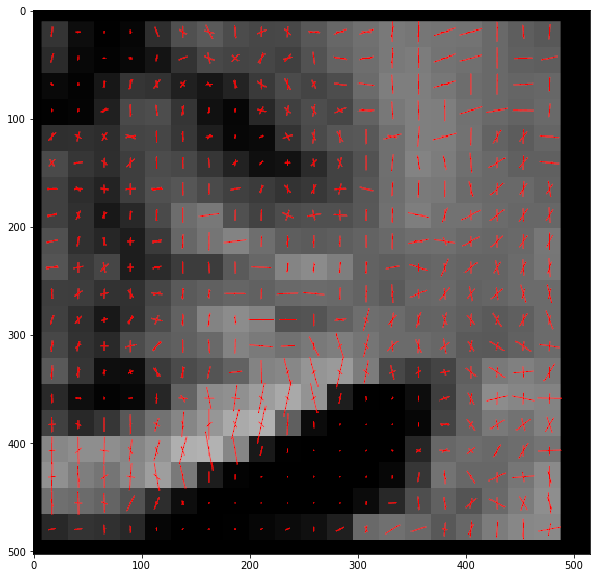

In [10]:
import matplotlib.image as mpimg
img = mpimg.imread('dipy.png')
plt.figure(figsize=[10, 10])
plt.imshow(img[100:-97, 100:-85])

Seems like two sticks overparameterize the problem in the corpus callosum, but on the right we can see consistent crossings. Possibly MIX can do a slighly better job, but it looks like we need somethings that enforces sparsity in the volume fractions.

## References
- Behrens, Timothy EJ, et al. "Characterization and propagation of uncertainty in diffusion‐weighted MR imaging." Magnetic resonance in medicine 50.5 (2003): 1077-1088